This is my solution to an exercise to make a spam classifier using Apache SpamAssassin’s public datasets, which I am writing to learn about machine learning. The exercise is from 
_Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition_, by
Aurélien Géron.

Copyright (C) 2022 Chris March <https://github.com/chrismarch>

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

## Contents
- [Load and Preprocess](#Load-and-Preprocess)
- [Train](#Train)
-- [Validate](#Validate)
- [Tuning](#Tuning)
- [Test](#Test)

## Load and Preprocess

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import re
import email
from email import policy
from io import StringIO
import joblib

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    ''' MLStripper by "Olivier Le Floch" https://stackoverflow.com/a/925630 '''
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self): 
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
def email_get_body(b):
    ''' 
    email_get_body by Todor Minikov https://stackoverflow.com/a/32840516
    (this seems to be more robust, or at least easier to use without errors than email.Parser.get_body)
    '''
    body = ""
    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # decode
                break
    # not multipart - i.e. plain text, no attachments, keeping fingers crossed
    else:
        body = b.get_payload(decode=True)

    return body

In [133]:
spam_key = 'is_spam'

def load_email_files_to_dataframe():
    vocabulary = {}
    too_common_words = {}
    file_paths_to_mail_dicts = {}
    file_index = 0
    #result = pd.DataFrame(data=file_paths_to_mail_dicts.values(), columns=columns, dtype=pd.SparseDtype(pd.UInt8Dtype())) # has to be nan to start, fill_value=0))     
    #df_type = 'Sparse[int]';#pd.SparseDtype(pd.UInt8Dtype())
    #result = pd.DataFrame(dtype=df_type) # has to be nan to start, fill_value=0))     

    for parent_dir, subdirs, files in os.walk('.'):
        #print(parent_dir)
        #print(subdirs)
        #print('---')
        html_regex = re.compile(r"(<html>|<HTML>)(.*)(<\/html>|<\/HTML>)", re.DOTALL)
        hamdir = '_ham' in parent_dir
        spamdir = 'spam' in parent_dir
        if hamdir or spamdir:
            for file in files:
                file_index += 1
                rel_file_path = os.path.join(parent_dir, file) 
                #print(rel_file_path)
                with open(rel_file_path, 'r', encoding='iso-8859-1') as f:
                #with open(rel_file_path, 'rb') as f:
                    f_str = f.read()   
                    msg = email.message_from_string(f_str, policy=policy.default)
                    #msg = email.parser.BytesParser(policy=policy.default).parse(f)
                    if file_index % 1000 == 0:
                        print(str(file_index))
                    subject = msg['subject']
                    #print(subject)
                    #print(msg['header'])
                    #body = msg.get_body(preferencelist=('html', 'plain'))
                    #if not body:
                    #    continue
                    #body = body.get_content()
                    body = str(email_get_body(msg))
                    #print(body)
                    html_match = html_regex.search(body)
                    #print(html_match)
                    if html_match:
                        body = html_match.group(2)
                        #print('------------')
                        #print(body)
                        #print('------------')
                    body_strip = strip_tags(body)
                    #body_strip = re.sub(r"[()\"\'-]", '', body_strip)
                    body_strip = re.sub(r"\\n", ' ', body_strip)
                    #print(body_strip)
                    mail_tokens = body_strip.split()
                    if subject:
                        mail_tokens += subject.split()
                    mail_dict = {}
                    mail_rejected_tokens = []
                    for token in mail_tokens:
                        if token in mail_dict:
                            mail_dict[token] = mail_dict[token] + 1
                            too_common_words[token] = 0
                            mail_dict.pop(token)
                            vocabulary.pop(token)
                        elif token not in too_common_words:
                            mail_dict[token] = 1
                            vocabulary[token] = 0
                    mail_dict[spam_key] = 1 if 'spam' in rel_file_path else 0
                    file_paths_to_mail_dicts[rel_file_path] = mail_dict
                    #mail_df = pd.DataFrame.from_dict(mail_dict, dtype=df_type)
                    #mail_df = pd.DataFrame(data=[mail_dict], dtype=df_type)
                    #result = pd.concat([result, mail_df])
                    #print(mail_tokens)                            
                    #print(mail_dict)
                    #print(mail_rejected_tokens)
                #if file_index > 100:
                #break
    print('finished loading emails')
    
    columns = [target_label_col] + list(vocabulary.keys())
    
    '''
    # for each mail, encode
    for file_path in file_paths_to_mail_dicts:
        mail_dict = file_paths_to_mail_dicts[file_path]
        for word in mail_dict:
            n_word = mail_dict[word]
            if n_word > 255:
                #print('!!!!!!', word)
                mail_dict.remove(word)
        mail_dicts.append(mail_dict)
    '''
    #mail_dicts = []
    #for path in file_paths_to_mail_dicts:
    #    mail_dicts.append(file_paths_to_mail_dicts[path])
    #print('finished constructing rows')
    #df_type = 'Sparse[int]'#pd.SparseDtype(pd.UInt8Dtype())
    #return pd.DataFrame.from_dict(row_dict, orient='index',dtype=pd.SparseDtype(np.uint8))
    # TODO convert to zero fill sparse from nan sparse and serialize zero fill sparse
    #nan_df = pd.DataFrame(data=mail_dicts, columns=columns, dtype=pd.SparseDtype(np.uint8)) # has to be nan to start, fill_value=0))
    #return pd.DataFrame(data=nan_df, dtype=pd.SparseDtype(np.uint8, fill_value=0))
    #return pd.DataFrame(data=list(file_paths_to_mail_dicts.values()), columns=columns, dtype='Sparse[float]')
        #"    nan_df = pd.DataFrame(data=mail_dicts, columns=columns, dtype=pd.SparseDtype(np.dtype('float64'))) # has to be nan to start, fill_value=0))\n",

    #return pd.DataFrame(data=mail_dicts, columns=columns, dtype=pd.SparseDtype(np.dtype('float64')))
    return pd.DataFrame(data=file_paths_to_mail_dicts.values(), columns=columns, dtype=pd.SparseDtype(pd.UInt8Dtype()))

In [134]:
# warning: this can take a couple/few minutes    
all_data = load_email_files_to_dataframe()
print(all_data.sparse.density)
print(all_data.info())

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
finished loading emails
0.0003544377510030051
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10751 entries, 0 to 10750
Columns: 131171 entries, is_spam to https://listman.redhat.com/
dtypes: Sparse[UInt8, <NA>](131171)
memory usage: 2.9 MB
None


In [135]:
joblib.dump(all_data, "spamham.pkl")

['spamham.pkl']

In [132]:
#all_data = None
nan_data = joblib.load("spamham.pkl")
print(nan_data.info())
#all_data = pd.DataFrame(data=nan_data, dtype=pd.SparseDtype(np.dtype('float64'), fill_value=0))
#nan_data = None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10751 entries, 0 to 10750
Columns: 131170 entries, b"Friend,Now to https://listman.redhat.com/
dtypes: Sparse[UInt8, <NA>](131170)
memory usage: 2.8 MB
None


In [138]:
print(target_label_col in all_data)
print(all_data.info())

True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10751 entries, 0 to 10750
Columns: 131171 entries, is_spam to https://listman.redhat.com/
dtypes: Sparse[UInt8, <NA>](131171)
memory usage: 2.9 MB
None


In [146]:
all_dense = pd.DataFrame(data=all_data, dtype='Sparse[int]')
print(all_dense.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10751 entries, 0 to 10750
Columns: 131171 entries, is_spam to https://listman.redhat.com/
dtypes: Sparse[int64, 0](131171)
memory usage: 5.7 MB
None


In [136]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [147]:
print(all_data.sparse.density)
target_label_col = spam_key
y_all = all_dense[target_label_col]
for train_indexes, test_indexes in split.split(all_dense, y_all):
    strat_train_set = all_dense.loc[train_indexes]
    strat_test_set = all_dense.loc[test_indexes]

#print(list(strat_train_set))
X_train = strat_train_set.drop(target_label_col, axis=1)
y_train = strat_train_set[target_label_col].copy()
strat_train_set = None

# test data split from train.csv, since test.csv has no labels
X_test = strat_test_set.drop(target_label_col, axis=1)
y_test = strat_test_set[target_label_col].copy()
strat_test_set = None

0.0003544377510030051


In [22]:
X_test_dense = X_test.sparse.to_dense()
print(X_test_dense.memory_usage())
for col in list(X_test_dense):
    print(col)
    X_test_dense[col] = pd.to_numeric(X_test_dense[col], downcast='unsigned')
X_test_dense.memory_usage()
#compact = pd.DataFrame(data=nan_df, dtype=pd.SparseDtype(np.dtype('float64'), fill_value=0))

Index                          17208
b"Friend,Now                   17208
you                            17208
can                            17208
copy                           17208
                               ...  
"rpm2cpio                      17208
-dimv"                         17208
db4                            17208
rpm-list@redhat.com            17208
https://listman.redhat.com/    17208
Length: 161295, dtype: int64
b"Friend,Now
you
can
copy
DVD's
and
Games
http://www.terra.es/personal9/iop1008/
BACKUP
DVD
VIDEO's
WITH
YOUR
CD-R
BURNER
With
321
studio's
software,
now
any
Playstation
Game.
Never
buy
another
backup
movie
again.
Just
it!
This
is
the
first
time
this
software
being
made
available
to
public.
All
need
burn
your
own
Video,
included
in
Studio's
package
Copy
Plus!
The
movies
will
play
a
standard
player.
detailed,
easy
follow,
step-by-step
instructions,
BURN
Video
using
nothing
more
than
DVD-ROM
drives.
Purchase
copy!
Click
below.
Order
today
receive!
*Step
by
Ste

KeyboardInterrupt: 

In [138]:
import sys

def get_largest_user_globals():
    ''' Adapted from https://stackoverflow.com/a/40997868 by Abdou '''
    
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('X_train', 11097096016),
 ('X_test', 2775564376),
 ('all_data', 22218336),
 ('df', 22218336),
 ('strat_train_set', 17798684),
 ('nan_data', 15269688),
 ('strat_test_set', 4422100),
 ('y_train', 105260),
 ('train_indexes', 68912),
 ('y_test', 26344),
 ('test_indexes', 17320),
 ('LinearSVC', 1472),
 ('GridSearchCV', 1192),
 ('MLStripper', 1192),
 ('BaseEstimator', 1064),
 ('ColumnTransformer', 1064),
 ('HTMLParser', 1064),
 ('KNeighborsClassifier', 1064),
 ('OneHotEncoder', 1064),
 ('Pipeline', 1064),
 ('RandomForestClassifier', 1064),
 ('SGDClassifier', 1064),
 ('SimpleImputer', 1064),
 ('StandardScaler', 1064),
 ('StratifiedShuffleSplit', 1064),
 ('TransformerMixin', 1064),
 ('VocabSimplifier', 1064),
 ('MultinomialNB', 896),
 ('StringIO', 416),
 ('cross_val_predict', 136),
 ('cross_val_score', 136),
 ('display_estimator_cv_scores', 136),
 ('display_scores', 136),
 ('email_get_body', 136),
 ('f1_score', 136),
 ('load_email_files_to_dataframe', 136),
 ('print_cv_scores', 136),
 ('stri

## Estimator Scoring

In [148]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

linsvc_clf = LinearSVC(C=.1)
mnb_clf = MultinomialNB()                       

In [74]:
def display_scores(estimator, scores):
    print("\n")
    print(type(estimator).__name__)
    #print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
        
def display_estimator_cv_scores(estimator, X, y): 
    scores = cross_val_score(estimator, X, y, cv=5)
    display_scores(estimator, scores)

def print_cv_scores(estimators, X, y):
    scores_and_estimators = []
    for e in estimators:
        scores = cross_val_score(e, X, y, cv=5)
        scores_and_estimators.append((scores.mean(), scores, e))
        
    scores_and_estimators.sort(key = lambda x: x[0], reverse=True)
    for mean, scores, e in scores_and_estimators:
        display_scores(e, scores)
 
'''
words only, no replacement
MultinomialNB
Mean: 0.9759302325581395
Standard deviation: 0.0023139242723409837

unfiltered tokens (no headers or html tags, #body_strip = re.sub(r"[()\"\'-]", '', body_strip))
MultinomialNB
Mean: 0.9853488372093022
Standard deviation: 0.002156655464068763

unfiltered tokens (no headers or html tags,
MultinomialNB
Mean: 0.9856976744186046
Standard deviation: 0.0022845212446963464
'''

estimators = [mnb_clf]#, linsvc_clf]
print_cv_scores(estimators, X_train, y_train)



MultinomialNB
Mean: 0.9856976744186046
Standard deviation: 0.0022845212446963464


## Tuning

In [201]:
import re
import string

class VocabSimplifier(BaseEstimator, TransformerMixin):
    
    def __init__(self, to_lower=False, strip_punctuation=False, replace_urls=True, replace_numbers=False): # no *args or **kargs
        self.to_lower = to_lower
        self.strip_punctuation = strip_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
                
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def apply_simplifications(self, word):
        if (word == spam_key):
            return word
        
        if (self.to_lower):
            word = word.lower()
            
        if (self.strip_punctuation):
            word = word.translate(str.maketrans('', '', string.punctuation))
            
        if (self.replace_urls):
            word = re.sub(r'http\S+', '_URL_', word)
            
        if (self.replace_numbers):
            word = re.sub(r'[0-9]+', '_N_', word)
        return word
            
    def transform(self, X : pd.DataFrame):
        print("VocabSimplifier.transform in.shape:", X)
        cols_to_drop = []
        simplified_vocab = {}
        vocab = list(X)
        n_vocab = len(vocab)
        progress_size = n_vocab/10
        for i, word in enumerate(vocab):
            if i % progress_size == 0:
                print(i, '/', n_vocab)
#            print(word)
            w = self.apply_simplifications(word)
#            print(i, w, word)
            if not w in simplified_vocab:
                simplified_vocab[w] = [word]
            else:
                #w_i = int(simplified_vocab[w])
                print(("COLUMN DEL", w, i, word))
                simplified_vocab[w].append(word)
                cols_to_drop.append(word)

        for similar_words in simplified_vocab.values():      
            if len(similar_words) > 1:
                main_col_for_w = similar_words[0]        
                print(main_col_for_w)
                sparse_type = X.dtypes[main_col_for_w]
                '''
                print(X.dtypes[main_col_for_w])
                X[main_col_for_w] = X[main_col_for_w].sparse.to_dense()
                print(X.dtypes[main_col_for_w])
                for word in similar_words:
                    if word != main_col_for_w:
                        print(X.dtypes[main_col_for_w])
                        X[main_col_for_w] += X[word].sparse.to_dense()                        
                '''
                X[main_col_for_w] = X[similar_words].sum(axis=1).astype(sparse_type)

        #print("VocabSimplifier.transform cols_to_drop:", cols_to_drop)
        #print(X)
        X.drop(columns=cols_to_drop, inplace=True)
        print("VocabSimplifier.transform out.shape:", X.info())
        return X

## Pipeline

hyperparameters to your preparation pipeline to control whether or not to 
- (strip off email headers)
- convert each email to lowercase, 
- remove punctuation, 
- replace all URLs with “URL,” 
- replace all numbers with “NUMBER,” 
- (or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).)

Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision

In [202]:
#word_regex = re.compile(r"^[(]?((mp3|MP3)[sS]?|[a-zA-Z]+|[a-zA-Z]+[-\/]?[a-zA-Z]+|[a-zA-Z]+[-\/]?[a-zA-Z]+[']?[a-zA-Z]+)([)]?[!?]+|[!?]+[)]?|[.,;:)]?)$")

mnb_param_grid = [
    {'alpha': [0, .5, 1], 'fit_prior': [True, False] }
  ]

grid_search = GridSearchCV(mnb_clf, mnb_param_grid, cv=5,
                           #return_train_score=True, 
                           verbose=1)

#col_trans.named_transformers_["cat"].handle_unknown = 'ignore' # for dropping attributes

main_pipeline = Pipeline([
    ('simple', VocabSimplifier()),
 #   ('dropper', AttributesDropper()),
    ('mnb', MultinomialNB()),
    #('grid', grid_search)
])

param_main = [
    {'simple__to_lower': [False, True]},
    {'simple__strip_punctuation': [False, True]},
    {'simple__replace_urls': [False, True]},
    {'simple__replace_numbers': [False, True]}
  ]

full_pipeline = GridSearchCV(main_pipeline, param_main, cv=5,
                           verbose=2)#, error_score='raise')

In [203]:
pipe_out = main_pipeline.fit(X_train.copy(), y_train)
X_train.info()

VocabSimplifier.transform in.shape:        b"Friend,Now  Games  BACKUP  VIDEO's  BURNER  studio's  Game.  Video,  \
20                0      0       0        0       0         0      0       0   
1033              0      0       0        0       0         0      0       0   
9885              0      0       0        0       0         0      0       0   
9501              0      0       0        0       0         0      0       0   
10613             0      0       0        0       0         0      0       0   
...             ...    ...     ...      ...     ...       ...    ...     ...   
3745              0      0       0        0       0         0      0       0   
8694              0      0       0        0       0         0      0       0   
10400             0      0       0        0       0         0      0       0   
5562              0      0       0        0       0         0      0       0   
10180             0      0       0        0       0         0      0       0   

   

('COLUMN DEL', '_URL_', 85101, 'http://www.newsisfree.com/click/-6,8341698,1440/')
('COLUMN DEL', '_URL_', 85117, 'http://ie.suberic.net/~kevin')
('COLUMN DEL', '_URL_', 85134, 'http://boingboing.net/#85516563')
('COLUMN DEL', '_URL_', 85154, 'http://www.tcj.com/247/i_rall.html')
('COLUMN DEL', '_URL_', 85155, 'http://www.quicktopic.com/16/H/de7BfPnMekg')
('COLUMN DEL', '_URL_', 85158, 'http://www.guardian.co.uk/elsewhere/journalist/story/0,7792,773258,00.')
('COLUMN DEL', 'b"_URL_', 85169, 'b"http://www.hughes-family.org/bugzilla/show_bug.cgi?id=886')
('COLUMN DEL', '_URL_', 85176, 'http://diveintomark.org/archives/2002/09/25.html#maps')
('COLUMN DEL', '_URL_', 85185, 'http://www.wired.com/news/school/0,1383,54916,00.html')
('COLUMN DEL', '_URL_', 85186, 'http://www.newsisfree.com/click/-5,8298180,1717/')
('COLUMN DEL', '_URL_', 85188, 'http://www.newsisfree.com/Images/fark/xent.gif')
('COLUMN DEL', '_URL_', 85330, 'http://www.nytimes.com/2002/08/25/national/25FBI.html?todaysheadlines

(http://admanmail.com/subscription.asp?em=JM@NETNOTEINC.COM&l=SGO)
window.open("http://www.ouweilighting.com");
"http://www.radisson-chicago.com"
>http://www.thaiworkathome.com/unsubscribe.php
url(http://images.lockergnome.com/images/issue/top-right.gif);
\thttp://use.perl.org/my/messages/
b'http://www.rebackee.com/cursos2/contraloria.htm
Websie:http://www.wjjzzs.com\r
open("http://www.pointcom.com","_top");}
b"http://www.nme.com/news/102774.htm
\'http0:python\'
>>http://www.frogstone.net/Cafe/CafeForteana.html
[1]http://www.theperlreview.com
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8600 entries, 20 to 10180
Columns: 123082 entries, b"Friend,Now to rpm-list@redhat.com
dtypes: Sparse[int64, 0](123081), int64(1)
memory usage: 4.8 MB
VocabSimplifier.transform out.shape: None


/Users/chrismarch/OtherRepos/ml/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8600 entries, 20 to 10180
Columns: 131170 entries, b"Friend,Now to https://listman.redhat.com/
dtypes: Sparse[int64, 0](131169), int64(1)
memory usage: 5.0 MB


In [571]:
pipe_out = full_pipeline.fit(X_train, y_train)
#pipe_out = main_pipeline.fit(X_train, y_train)
#print(grid_search.best_params_)
print(full_pipeline.best_params_)
print(full_pipeline.best_estimator_.steps[2][1].best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................dropper__min_importance=0.061; total time=   0.9s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................

## Test

In [204]:
from sklearn.metrics import precision_score, recall_score

#X_test_tr = col_trans.fit_transform(X_test)
#print(list(X_train))
#print(list(X_test))

# forest
# 0.785314498933902
# 0.7706711343254163 drop age

# knn
# 0.7795566502463054

# sgd
# 0.777129750982962

y_test_predict = pipe_out.predict(X_test)
print(precision_score(y_test, y_test_predict)) # first priority for spam classifier
print(recall_score(y_test, y_test_predict))    # second priority
score = f1_score(y_test, y_test_predict, average="macro")
score

VocabSimplifier.transform in.shape:        b"Friend,Now  Games  BACKUP  VIDEO's  BURNER  studio's  Game.  Video,  \
2881              0      0       0        0       0         0      0       0   
6031              0      0       0        0       0         0      0       0   
7287              0      0       0        0       0         0      0       0   
10533             0      0       0        0       0         0      0       0   
7681              0      0       0        0       0         0      0       0   
...             ...    ...     ...      ...     ...       ...    ...     ...   
565               0      0       0        0       0         0      0       0   
2209              0      0       0        0       0         0      0       0   
8741              0      0       0        0       0         0      0       0   
10154             0      0       0        0       0         0      0       0   
4362              0      0       0        0       0         0      0       0   

   

('COLUMN DEL', '_URL_', 85676, 'http://www.nobel.se')
('COLUMN DEL', '_URL_', 85720, 'http://boingboing.net/#85485805')
('COLUMN DEL', '_URL_', 85722, 'http://www.craphound.com/images/flyingcar.jpg]')
('COLUMN DEL', '_URL_', 85729, 'http://www.moller.com/skycar/')
('COLUMN DEL', '_URL_', 85730, 'http://www.quicktopic.com/boing/H/kpP4y4RMJ63SA')
('COLUMN DEL', '_URL_', 85808, 'http://www.digitalsluice.com/josh/pager')
('COLUMN DEL', '_URL_', 85812, 'http://diveintomark.org/archives/2002/09/23.html#the_semantic_web_makes_me_sick')
('COLUMN DEL', '_URL_', 85835, 'http://www.peerfear.org/')
('COLUMN DEL', '>_URL_', 85947, '>http://www.linux.ie/mailman/listinfo/ilug')
('COLUMN DEL', '_URL_', 85992, 'http://www.newsisfree.com/click/-0,8597653,215/')
('COLUMN DEL', '_URL_', 86000, 'http://scriptingnews.userland.com/backissues/2002/09/25#When:8:33:10AM')
('COLUMN DEL', '_URL_', 86005, 'http://www.wired.com/news/mp3/0,1285,55356,00.html')
('COLUMN DEL', '_URL_', 86013, 'http://www.newsisfree.co

(http://admanmail.com/subscription.asp?em=JM@NETNOTEINC.COM&l=SGO)
window.open("http://www.ouweilighting.com");
"http://www.radisson-chicago.com"
>http://www.thaiworkathome.com/unsubscribe.php
url(http://images.lockergnome.com/images/issue/top-right.gif);
\thttp://use.perl.org/my/messages/
b'http://www.rebackee.com/cursos2/contraloria.htm
Websie:http://www.wjjzzs.com\r
open("http://www.pointcom.com","_top");}
b"http://www.nme.com/news/102774.htm
\'http0:python\'
>>http://www.frogstone.net/Cafe/CafeForteana.html
[1]http://www.theperlreview.com
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151 entries, 2881 to 4362
Columns: 123082 entries, b"Friend,Now to rpm-list@redhat.com
dtypes: Sparse[int64, 0](123082)
memory usage: 1.1 MB
VocabSimplifier.transform out.shape: None
0.9689922480620154
0.9868421052631579


0.9827762433021079

## Performance
### ROC Curve

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................dropper__min_importance=0.061; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................

[CV] END .......................dropper__min_importance=0.08; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits


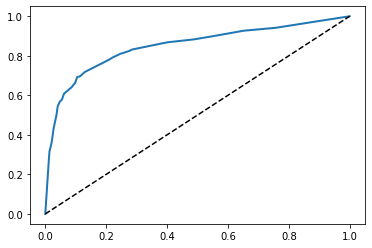

0.8486528657371482

In [573]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

y_scores = cross_val_predict(pipe_out, X_train, y_train, cv=3,
                             method="predict_proba")
                             #method="decision_function") #SGD
    
y_scores = y_scores[:, 1]   # score = proba of positive class

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()
# forest
# 0.856909225929727
# 0.8557619297938204 drop age

# knn
# 0.8406051048420068

# sgd
# n/a

roc_auc_score(y_train, y_scores)